# Sample notebook on how to evaluate DoE designs
- this notebook will be sitting in the docs folder. to run it, move it to the src folder

### Necessary imports

In [1]:
import functions.evaluation.design as doe_eval
import pandas as pd

# Sample using CCD
### Create a sample design
For this example, we are generating a sample design.
In your application, you would, instead, import your design as a Pandas dataframe
The final outputs should be:
- **design**: Pandas dataframe of the experimental design
- **formula**: string of the multiple linear regression model

In [2]:
# create a sample CCD
import dexpy.factorial

# Function to add axial points
def add_axial_points(design, alpha=1.414):
    factors = design.columns
    axial_points = []
    
    for factor in factors:
        for level in [-alpha, alpha]:
            point = [0] * len(factors)
            point[factors.get_loc(factor)] = level
            axial_points.append(point)
    
    axial_df = pd.DataFrame(axial_points, columns=factors)
    return pd.concat([design, axial_df], ignore_index=True)

# Generate full factorial design
design = pd.DataFrame(dexpy.factorial.build_full_factorial(3),columns=['A','B','C'])

# Add axial points
design = add_axial_points(design)

design.loc[len(design)] = {'A':0,'B':0,'C':0}

formula = 'A + B + C + A:B + A:C + B:C + I(A**2) + I(B**2) + I(C**2)'

print('Design:')
print(design)
print('')
print('Fromula:')
print(formula)


Design:
        A      B      C
0  -1.000 -1.000 -1.000
1  -1.000 -1.000  1.000
2  -1.000  1.000 -1.000
3  -1.000  1.000  1.000
4   1.000 -1.000 -1.000
5   1.000 -1.000  1.000
6   1.000  1.000 -1.000
7   1.000  1.000  1.000
8  -1.414  0.000  0.000
9   1.414  0.000  0.000
10  0.000 -1.414  0.000
11  0.000  1.414  0.000
12  0.000  0.000 -1.414
13  0.000  0.000  1.414
14  0.000  0.000  0.000

Fromula:
A + B + C + A:B + A:C + B:C + I(A**2) + I(B**2) + I(C**2)


### Calculate power and VIF
- intercept is usually ignored
- all values are reported, meaning there is no aliasing

In [3]:
evaluation = doe_eval.evaluate_design(design,formula)
print(evaluation)

              Power       VIF
Term                         
Intercept  0.507015  9.995470
A          0.789108  1.000000
B          0.789108  1.000000
C          0.789108  1.000000
A:B        0.622803  1.000000
A:C        0.622803  1.000000
B:C        0.622803  1.000000
I(A ** 2)  0.953376  1.199577
I(B ** 2)  0.953376  1.199577
I(C ** 2)  0.953376  1.199577


### Covariance and correlation maps

#### Covariance matrix heatmap

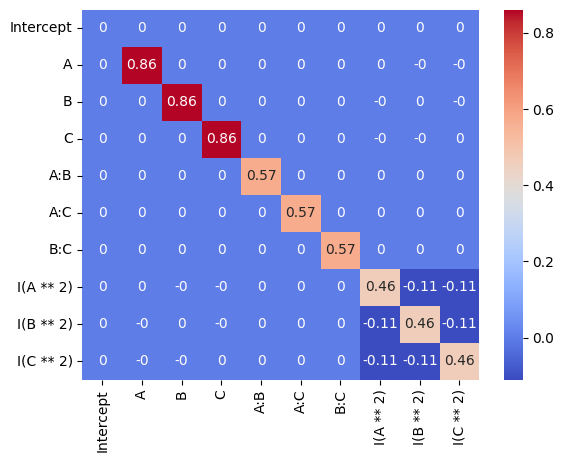

In [4]:
cov_df = doe_eval.calculate_covariance_matrix(design,formula)
doe_eval.plot_matrix_heatmap(cov_df)

#### Correlation matrix heatmap

c:\Users\mhidalgo\OneDrive\OneDrive - JLR\Projects\ML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mhidalgo\OneDrive\OneDrive - JLR\Projects\ML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


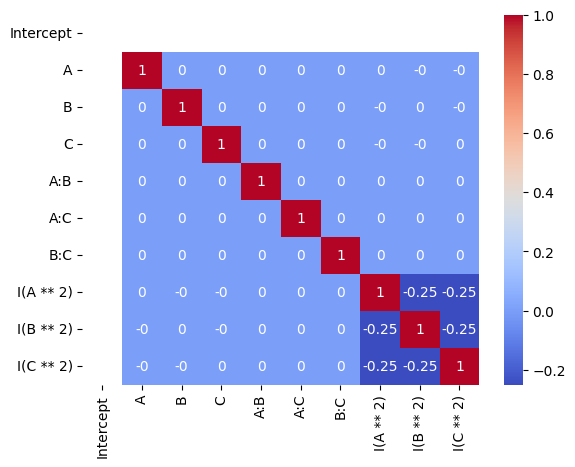

In [5]:
corr_df = doe_eval.calculate_correlation_matrix(design,formula)
doe_eval.plot_matrix_heatmap(corr_df)

#### Correlation or covariance matrix heatmap with custom colors
- custom colors are added using the cmap_colors kwarg which takes in a dict of value,color pairs

c:\Users\mhidalgo\OneDrive\OneDrive - JLR\Projects\ML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mhidalgo\OneDrive\OneDrive - JLR\Projects\ML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


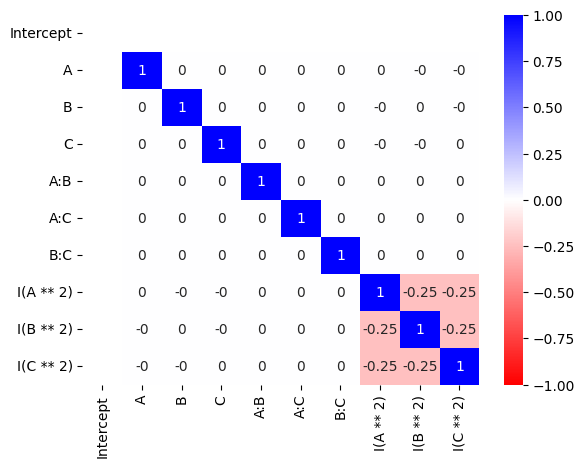

In [6]:
corr_df = doe_eval.calculate_correlation_matrix(design,formula)
doe_eval.plot_matrix_heatmap(corr_df, cmap_colors={-1:'red',0:'white',1:'blue'})

# Sample case where data is aliased or poorly designed

### Create a sample design
- Exact same workflow as the previous example, but this time, we will use a poor/aliased design
    - in this case, we are using a 2^3-1 fractional factorial

In [55]:
design = dexpy.factorial.build_factorial(3,4)
design.columns = ['A','B','C']
design.loc[len(design)] = design.iloc[-1] # add a replicate so that the design is not so sparse (having too sparse of a design can lead to issues in calculations, such as power)

formula = 'A + B + C + A:B'

print('Design:')
print(design)
print('')
print('Fromula:')
print(formula)


Design:
   A  B  C
0 -1 -1  1
1 -1  1 -1
2  1 -1 -1
3  1  1  1
4  1  1  1

Fromula:
A + B + C + A:B


### Design + formula contain aliased terms
- since there were aliased terms, the aliased terms were first removed then the design statistics were calculated.
- the alias list can also be checked using dexpy

In [56]:
evaluation = doe_eval.evaluate_design(design,formula)
print(evaluation)

print('')
alias_list, _ = dexpy.alias.alias_list(formula, design)
print(f'The alias list is {alias_list}')

              Power       VIF
Term                         
Intercept  0.617602  1.071429
A          0.243304  1.028571
B          0.243304  1.028571
C                 X         X
A:B               X         X

The alias list is ['C = A:B']


- since the design + formula were aliased, we can remedy this by using a simpler model.
- note that power can only be calculated if the # of terms in the formula < # experiments (this is why we added a replicate)

In [57]:
formula = 'A + B + C'
evaluation = doe_eval.evaluate_design(design,formula)
print(evaluation)

              Power      VIF
Term                        
Intercept  0.262756  1.09375
A          0.133952  1.05000
B          0.133952  1.05000
C          0.133952  1.05000


### Covariance matrix in an aliased design
- note the strong covariance between C and A:B

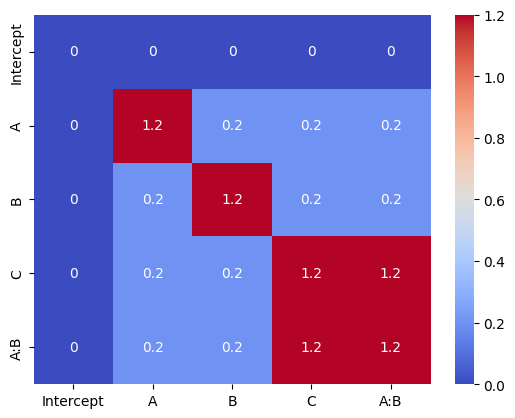

In [58]:
formula = 'A + B + C + A:B'
cov_df = doe_eval.calculate_covariance_matrix(design,formula)
doe_eval.plot_matrix_heatmap(cov_df)

### Correlation matrix in an aliased design
- note the strong correlation between C and A:B

c:\Users\mhidalgo\OneDrive\OneDrive - JLR\Projects\ML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mhidalgo\OneDrive\OneDrive - JLR\Projects\ML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


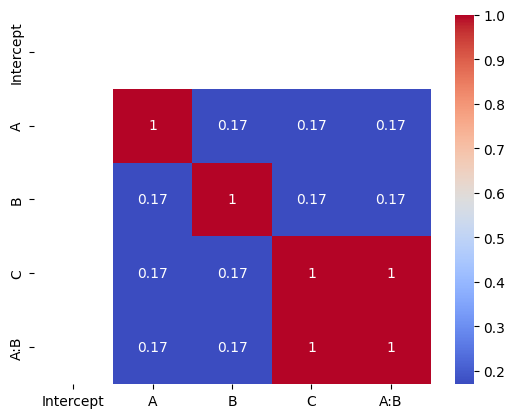

In [59]:
corr_df = doe_eval.calculate_correlation_matrix(design,formula)
doe_eval.plot_matrix_heatmap(corr_df)